In [7]:
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.core import Composition, Structure
from pymatgen.io.cif import CifParser, CifBlock
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.symmetry.groups import SpaceGroup
from pymatgen.core.operations import SymmOp

from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.core.structure import Structure

import numpy as np
import matplotlib.pyplot as plt

from decifer.utility import pxrd_from_cif
import torch

In [13]:
cif = "../../deCIFer/data/chili100k/raw/1000055.cif"
cif = "../../deCIFer/data/chili100k/raw/1000008.cif"
qmax = 10.0
qmin = 0.0
qstep = 0.01
base_fwhm = 0.05
eta = 0.5

In [14]:
structure = Structure.from_file(cif)
xrd_calculator = XRDCalculator(wavelength="CuKa")

q_cont = torch.arange(qmin, qmax, qstep, dtype=torch.float32)
overall_iq_cont = torch.zeros_like(q_cont)

                
# Determine two_theta_range based on qmin and qmax
max_q = ((4 * np.pi) / xrd_calculator.wavelength) * np.sin(np.radians(90))
if qmax >= max_q:
    two_theta_range = (0, 120)
else:
    tth_min = np.degrees(2 * np.arcsin((qmin * xrd_calculator.wavelength) / (4 * np.pi)))
    tth_max = np.degrees(2 * np.arcsin((qmax * xrd_calculator.wavelength) / (4 * np.pi)))
    two_theta_range = (tth_min, min(tth_max, 120))
                
pattern = xrd_calculator.get_pattern(structure, two_theta_range=two_theta_range)

# Convert 2θ (xrd_pattern.x) to Q (momentum transfer)
theta_radians = torch.tensor(np.radians(pattern.x / 2), dtype=torch.float32)
q_disc = 4 * np.pi * np.sin(theta_radians) / xrd_calculator.wavelength
iq_disc = torch.tensor(pattern.y, dtype=torch.float32)

# Compute Gaussian and Lorentzian widths (from FWHM)
sigma_gauss = base_fwhm / (2 * np.sqrt(2 * np.log(2)))
gamma_lorentz = base_fwhm / 2  # base Lorentzian width

delta_q = q_cont.unsqueeze(1) - q_disc.unsqueeze(0)

# Compute the Gaussian and Lorentzian components
gaussian_component = torch.exp(-0.5 * (delta_q / sigma_gauss) ** 2)
lorentzian_component = 1 / (1 + (delta_q / gamma_lorentz) ** 2)

pseudo_voigt = eta * lorentzian_component + (1 - eta) * gaussian_component

# Sum the contributions of each (redacted, oriented) discrete peak
phase_iq_cont = (pseudo_voigt * iq_disc).sum(dim=1)
# Normalize the phase contribution

phase_iq_cont /= (phase_iq_cont.max() + 1e-16)


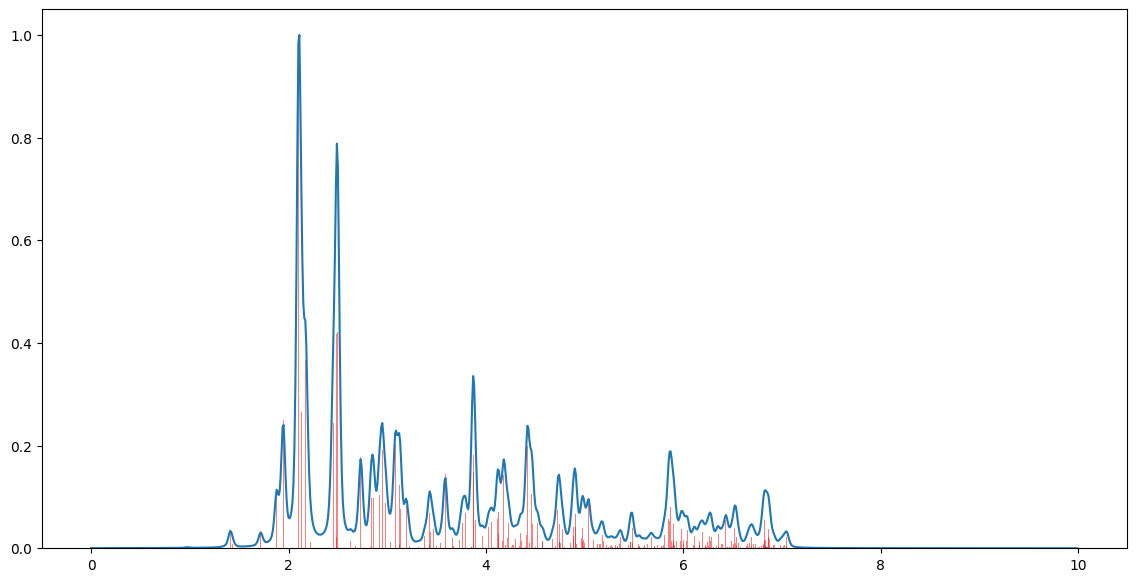

In [15]:
fig, ax = plt.subplots(figsize=(14,7))


plt.bar(q_disc, iq_disc/100, width=0.01, color='red', alpha=0.5)
plt.plot(q_cont, phase_iq_cont)

In [38]:
iq_disc

tensor([ 26.5024,  42.6731,  17.8006,   9.1216,  20.9223,  11.2982,   4.1477,
         11.8704,   8.4239,   5.3245,   0.9307,   3.5326,   7.3148,   1.3072,
          6.5241,   5.6364,   2.4462,   3.6224,   7.7911,   4.0682,   3.1024,
          3.7471,  17.3619,   9.9282, 100.0000])

In [37]:
q_disc

tensor([1.5113, 2.1372, 2.6176, 3.0225, 3.3793, 3.7018, 4.2745, 4.5338, 4.7790,
        5.0123, 5.2351, 5.4489, 5.6546, 6.0450, 6.2311, 6.4117, 6.5874, 6.7585,
        6.9254, 7.0884, 7.4036, 7.5563, 7.7059, 7.8527, 8.1384])